In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/31min_whisper_d0lib/DIARefLib_Lib4_report-lib.tsv'
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/31min_whisper_d0lib/DIARefLib_d0-d12.hdf'

In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {'Oxidation@M':['M(Oxidation)'],
     'Dimethyl@K':['K(Dimethyl)'],
     'Dimethyl@R':['R(Dimethyl)'],
     'Dimethyl@Any N-term':['(Dimethyl)']
    }
)
psm = target_lib.import_file(lib_location)

In [5]:
target_lib.precursor_df[target_lib.precursor_df['sequence'] == 'AAAAAAAAAPAAAATAPTTAATTAATAAQ']

,mod_sites,nAA,rt,genes,proteins,mods,sequence,charge,precursor_mz,mobility,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,0,29,38.028263,SRP14,SRP14_HUMAN,Dimethyl@Any N-term,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,799.41870,1.151563,0,28,0.378447,695.827270
1,0,29,38.169868,SRP14,SRP14_HUMAN,Dimethyl@Any N-term,AAAAAAAAAPAAAATAPTTAATTAATAAQ,4,599.81586,0.968437,28,56,0.379856,780.231014


In [6]:
flat_mz = target_lib.fragment_mz_df.iloc[1139600:1139628].values.flatten()
flat_intensity = target_lib.fragment_intensity_df.iloc[1139600:1139628].values.flatten()

flat_mz = flat_mz[flat_intensity > 0]
flat_intensity = flat_intensity[flat_intensity > 0]

print(flat_mz)
print(flat_intensity)

[888.51490779 775.43084382 688.39881541 574.35588797 461.27182399
 398.23979559 485.27182399 572.3038524  685.38791637 798.47198035
 775.43084382 688.39881541 574.35588797 461.27182399 374.23979559]
[0.26373506 1.         0.32084015 0.19485836 0.36580694 0.25652066
 0.23202193 0.6712515  0.6669107  0.1918155  0.6939311  0.32449043
 0.3636094  1.         0.1901069 ]


In [7]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y','b_modloss', 'y_modloss'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

res = model_mgr.predict_all(
    target_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

target_lib._precursor_df = res['precursor_df']
target_lib._fragment_mz_df = res['fragment_mz_df']
target_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-05-17 22:49:44> Using multiprocessing with 8 processes ...
2023-05-17 22:49:44> Predicting ms2 ...


100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


In [8]:
target_lib._precursor_df

,mod_sites,nAA,rt,genes,proteins,mods,sequence,charge,precursor_mz,mobility,rt_norm,ccs,frag_stop_idx,nce,instrument,frag_start_idx
0,0,7,7.454313,NDUFS3,NDUS3_HUMAN,Dimethyl@Any N-term,AANWYER,2,469.22995,0.833646,0.074183,338.819009,6,30,timsTOF,0
1,0;7,7,6.906344,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,2,381.24200,0.745114,0.068730,303.847594,12,30,timsTOF,6
2,0;7,7,7.012349,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,1,761.47675,1.289479,0.069785,262.922523,18,30,timsTOF,12
3,0;7,7,-30.147528,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,1,777.43524,1.283750,-0.300020,261.659091,24,30,timsTOF,18
4,0;7,7,-30.121391,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,2,389.22128,0.765000,-0.299760,311.843714,30,30,timsTOF,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113785,0,18,97.788193,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,4,534.29205,0.891875,0.973161,719.055810,1387316,30,timsTOF,1387299
113786,0,18,97.758507,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,2,1067.57690,1.261875,0.972866,508.683423,1387333,30,timsTOF,1387316
113787,0,18,28.030666,ACP1,PPAC_HUMAN,Dimethyl@Any N-term,VDSAATSGYEIGNPPDYR,2,970.45526,1.157292,0.278953,466.826178,1387350,30,timsTOF,1387333
113788,0,18,20.895695,RAD50,RAD50_HUMAN,Dimethyl@Any N-term,VFQGTDEQLNDLYHNHQR,2,1121.53540,1.223068,0.207948,492.886192,1387367,30,timsTOF,1387350


In [9]:

target_lib.precursor_df['decoy'] = 0
target_lib._precursor_df['channel'] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

In [10]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 113790/113790 [00:43<00:00, 2626.11it/s]


In [11]:
from alphabase.constants import modification

modification.add_new_modifications(
    {
        "Dimethyl:d12@Protein N-term": {
        "composition":"H(-2)2H(8)13C(2)"
        },
        "Dimethyl:d12@Any N-term": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@R": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@K": {
        "composition":"H(-2)2H(8)13C(2)",
        },
    }
)

In [12]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, 'Dimethyl@', 'Dimethyl:2H(4)@'),
    (8, 'Dimethyl@', 'Dimethyl:2H(6)13C(2)@'),
    (12, 'Dimethyl@', 'Dimethyl:d12@')
    ]:

    channel_lib = target_lib.copy()

    channel_lib._precursor_df['mods'] = channel_lib._precursor_df['mods'].str.replace(original_mod, new_mod)
    channel_lib._precursor_df['channel'] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()


In [13]:
for lib in channel_lib_list:
    target_lib.append(lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'b_modloss_z1', 'y_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'b_modloss_z1', 'y_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z2', 'b_modloss_z1', 'y_modloss_z1', 'b_modloss_z2'}.
  warnings.warn(


In [14]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.remove_unused_fragments()

In [15]:
target_lib.precursor_df.columns

Index(['mod_sites', 'nAA', 'rt', 'genes', 'proteins', 'mods', 'sequence',
       'charge', 'precursor_mz', 'mobility', 'rt_norm', 'ccs', 'frag_stop_idx',
       'nce', 'instrument', 'frag_start_idx', 'decoy', 'channel',
       'n_fragments', 'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4',
       'i_5'],
      dtype='object')

In [16]:
decoy_lib = target_lib.copy()

In [18]:
decoy_lib._precursor_df = target_lib._precursor_df[target_lib._precursor_df['channel'] == 0].copy()
decoy_lib.remove_unused_fragments()

In [19]:
decoy_lib.precursor_df

,mod_sites,nAA,rt,genes,proteins,mods,sequence,charge,precursor_mz,mobility,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,0,7,7.454313,NDUFS3,NDUS3_HUMAN,Dimethyl@Any N-term,AANWYER,2,469.22995,0.833646,...,0,0,7,0,0.583223,0.303146,0.090454,0.019721,0.003456,0.000000
1,0;7,7,6.906344,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,2,381.24200,0.745114,...,0,0,7,1,0.653035,0.266374,0.066413,0.012321,0.001858,0.000000
2,0;7,7,7.012349,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,1,761.47675,1.289479,...,0,0,9,2,0.653035,0.266374,0.066413,0.012321,0.001858,0.000000
3,0;7,7,-30.147528,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,1,777.43524,1.283750,...,0,0,9,3,0.657221,0.261171,0.066796,0.012799,0.002013,0.000000
4,0;7,7,-30.121391,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,2,389.22128,0.765000,...,0,0,9,4,0.657221,0.261171,0.066796,0.012799,0.002013,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113785,0,18,97.788193,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,4,534.29205,0.891875,...,0,0,13,113785,0.285969,0.330522,0.219187,0.106063,0.041090,0.013387
113786,0,18,97.758507,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,2,1067.57690,1.261875,...,0,0,21,113786,0.285969,0.330522,0.219187,0.106063,0.041090,0.013387
113787,0,18,28.030666,ACP1,PPAC_HUMAN,Dimethyl@Any N-term,VDSAATSGYEIGNPPDYR,2,970.45526,1.157292,...,0,0,22,113787,0.342773,0.347772,0.195818,0.079348,0.025648,0.006984
113788,0,18,20.895695,RAD50,RAD50_HUMAN,Dimethyl@Any N-term,VFQGTDEQLNDLYHNHQR,2,1121.53540,1.223068,...,0,0,24,113788,0.288281,0.342151,0.219714,0.100119,0.036045,0.010856


In [29]:
target_lib.decoy = 'diann'
decoy_lib.append_decoy_sequence()

In [31]:
from alphabase.spectral_library.decoy import (
    decoy_lib_provider
)
# register 'protein_reverse' to the decoy_lib_provider
import alphabase.protein.protein_level_decoy

decoy_lib_instance = (
    decoy_lib_provider.get_decoy_lib(
        'diann', decoy_lib
    )
)

In [22]:
decoy_lib_instance.append_decoy_sequence()

In [30]:
decoy_lib.precursor_df

,mod_sites,nAA,rt,genes,proteins,mods,sequence,charge,precursor_mz,mobility,...,decoy,channel,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5
0,0,7,7.454313,NDUFS3,NDUS3_HUMAN,Dimethyl@Any N-term,AANWYER,2,469.22995,0.833646,...,0,0,7,0,0.583223,0.303146,0.090454,0.019721,0.003456,0.000000
1,0;7,7,6.906344,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,2,381.24200,0.745114,...,0,0,7,1,0.653035,0.266374,0.066413,0.012321,0.001858,0.000000
2,0;7,7,7.012349,MTIF2,IF2M_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GSLTSLK,1,761.47675,1.289479,...,0,0,9,2,0.653035,0.266374,0.066413,0.012321,0.001858,0.000000
3,0;7,7,-30.147528,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,1,777.43524,1.283750,...,0,0,9,3,0.657221,0.261171,0.066796,0.012799,0.002013,0.000000
4,0;7,7,-30.121391,FKBP3,FKBP3_HUMAN,Dimethyl@Any N-term;Dimethyl@K,GTESISK,2,389.22128,0.765000,...,0,0,9,4,0.657221,0.261171,0.066796,0.012799,0.002013,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113785,0,18,97.788193,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,4,534.29205,0.891875,...,0,0,13,113785,0.285969,0.330522,0.219187,0.106063,0.041090,0.013387
113786,0,18,97.758507,PARP1,PARP1_HUMAN,Dimethyl@Any N-term,VEMLDNLLDIEVAYSLLR,2,1067.57690,1.261875,...,0,0,21,113786,0.285969,0.330522,0.219187,0.106063,0.041090,0.013387
113787,0,18,28.030666,ACP1,PPAC_HUMAN,Dimethyl@Any N-term,VDSAATSGYEIGNPPDYR,2,970.45526,1.157292,...,0,0,22,113787,0.342773,0.347772,0.195818,0.079348,0.025648,0.006984
113788,0,18,20.895695,RAD50,RAD50_HUMAN,Dimethyl@Any N-term,VFQGTDEQLNDLYHNHQR,2,1121.53540,1.223068,...,0,0,24,113788,0.288281,0.342151,0.219714,0.100119,0.036045,0.010856


In [31]:
decoy_lib_instance.calc_precursor_mz()
decoy_lib_instance.precursor_df
decoy_lib_instance.remove_unused_fragments()
decoy_lib_instance.calc_fragment_mz_df()

In [32]:
decoy_lib_instance.precursor_df.columns

Index(['proteins', 'rt', 'mods', 'sequence', 'nAA', 'charge', 'mobility',
       'genes', 'mod_sites', 'precursor_mz', 'rt_norm', 'ccs', 'frag_stop_idx',
       'nce', 'instrument', 'frag_start_idx', 'decoy', 'channel',
       'n_fragments', 'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4',
       'i_5'],
      dtype='object')

In [33]:
decoy_lib_instance.precursor_df['decoy'] = 1

In [34]:
target_lib.append(decoy_lib_instance)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'y_modloss_z1', 'b_modloss_z2', 'y_modloss_z2', 'b_modloss_z1'}.
  warnings.warn(


In [21]:
target_lib.precursor_df['n_fragments_allowed'] = target_lib.precursor_df['n_fragments']

In [35]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [23]:
target_lib.precursor_df = target_lib.precursor_df[target_lib.precursor_df['n_fragments'] >= 3].copy()
target_lib.remove_unused_fragments()

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

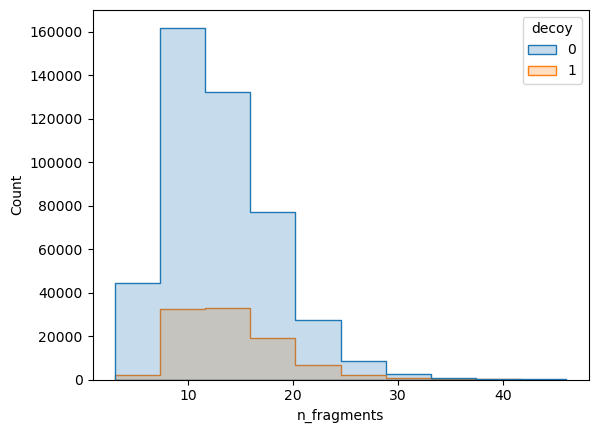

In [36]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x='n_fragments', hue='decoy', element='step', bins=10)

In [29]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(
    zip(
        target_lib.precursor_df['frag_start_idx'].values, 
        target_lib.precursor_df['frag_stop_idx'].values, 
        target_lib.precursor_df['n_fragments_allowed'].values
        )
    ):
    intensies = target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0

In [116]:
target_lib.precursor_df.drop(columns=['n_fragments'], inplace=True)

In [117]:
target_lib.precursor_df.columns

Index(['mobility', 'charge', 'mods', 'sequence', 'nAA', 'proteins', 'genes',
       'rt', 'mod_sites', 'precursor_mz', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'elution_group_idx', 'i_0', 'i_1',
       'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [37]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(target_lib.precursor_df, target_lib._fragment_mz_df)

In [52]:
target_lib.precursor_df['rt_norm'] = target_lib.precursor_df['rt']

<AxesSubplot:>

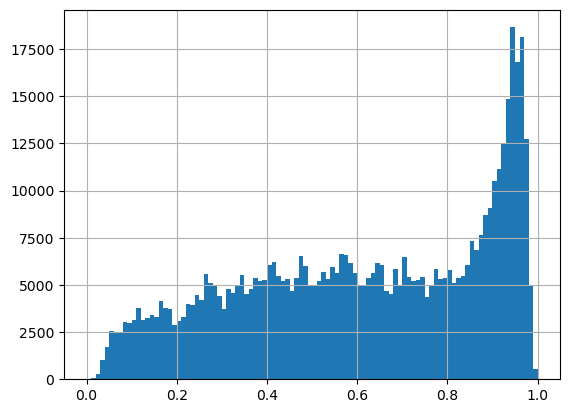

In [53]:
target_lib.precursor_df['rt_norm'].hist(bins=100)

In [54]:
target_lib.save_hdf(output_location)

In [40]:
target_lib.precursor_df[target_lib.precursor_df['sequence'] == 'AAAAAAAAAVSR']

,proteins,rt,mods,sequence,nAA,charge,mobility,genes,mod_sites,precursor_mz,...,n_fragments,elution_group_idx,i_0,i_1,i_2,i_3,i_4,i_5,mod_seq_hash,mod_seq_charge_hash
57398,ZFP91_HUMAN,-7.972940,Dimethyl@Any N-term,AAAAAAAAAVSR,12,1,1.208750,ZFP91,0,1028.584700,...,16,57398,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,11763025686078280147,11763025686078280148
57399,ZFP91_HUMAN,-7.949792,Dimethyl@Any N-term,AAAAAAAAAVSR,12,3,0.739896,ZFP91,0,343.533080,...,12,57399,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,11763025686078280147,11763025686078280150
57400,ZFP91_HUMAN,-7.915369,Dimethyl@Any N-term,AAAAAAAAAVSR,12,2,0.867708,ZFP91,0,514.796020,...,14,57400,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,11763025686078280147,11763025686078280149
171188,ZFP91_HUMAN,-7.972940,Dimethyl:2H(4)@Any N-term,AAAAAAAAAVSR,12,1,1.208750,ZFP91,0,1032.609826,...,16,57398,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,901488921416213885,901488921416213886
171189,ZFP91_HUMAN,-7.949792,Dimethyl:2H(4)@Any N-term,AAAAAAAAAVSR,12,3,0.739896,ZFP91,0,344.874793,...,12,57399,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,901488921416213885,901488921416213888
171190,ZFP91_HUMAN,-7.915369,Dimethyl:2H(4)@Any N-term,AAAAAAAAAVSR,12,2,0.867708,ZFP91,0,516.808551,...,14,57400,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,901488921416213885,901488921416213887
284978,ZFP91_HUMAN,-7.972940,Dimethyl:2H(6)13C(2)@Any N-term,AAAAAAAAAVSR,12,1,1.208750,ZFP91,0,1036.629089,...,16,57398,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,6286504576706204113,6286504576706204114
284979,ZFP91_HUMAN,-7.949792,Dimethyl:2H(6)13C(2)@Any N-term,AAAAAAAAAVSR,12,3,0.739896,ZFP91,0,346.214547,...,12,57399,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,6286504576706204113,6286504576706204116
284980,ZFP91_HUMAN,-7.915369,Dimethyl:2H(6)13C(2)@Any N-term,AAAAAAAAAVSR,12,2,0.867708,ZFP91,0,518.818183,...,14,57400,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,6286504576706204113,6286504576706204115
398768,ZFP91_HUMAN,-7.972940,Dimethyl:d12@Any N-term,AAAAAAAAAVSR,12,1,1.208750,ZFP91,0,1040.657292,...,16,57398,0.573042,0.305691,0.095345,0.02187,0.004052,0.0,13808738405062251928,13808738405062251929
